# Word Frequency Analysis

## Overall text

In [1]:
import json
import pandas as pd

with open("forums_info/english_words/english_words.json", "r") as f:
    word_data = json.load(f)

# Create a dataframe from the json data, where one column are the keys and the other the values
df = pd.DataFrame(word_data.items(), columns=["Word", "frequency"])

# Sort the dataframe by the frequency column
df = df.sort_values(by="frequency", ascending=False).reset_index(drop=True)

df.head(20)

,Word,frequency
0,windows,24257
1,mb,20706
2,pantos,18704
3,drivers,14041
4,ki,13708
5,ram,11792
6,server,11614
7,video,11337
8,thanks,11298
9,bios,11044


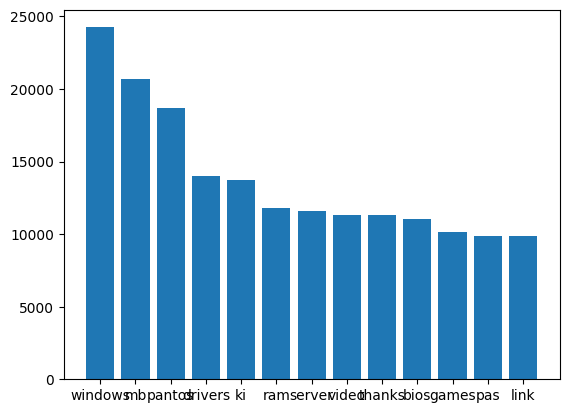

In [2]:
import matplotlib.pyplot as plt 

plt.rcParams['figure.facecolor'] = 'white'

cutoff = 13
# Create a histogram of the frequency of the first 80 words
plt.bar(df["Word"][:cutoff], df["frequency"][:cutoff])
plt.show()


# Filter out the greek words

In [7]:
from gr_nlp_toolkit import Pipeline
import tqdm


nlp = Pipeline("g2g_lite")

english_words = df["Word"]
transliterated_words = []

# Transliterate every candidate word
for english_word in tqdm.tqdm(english_words):
    doc = nlp(english_word)
    transliterated_words.append(doc.text)

  0%|          | 26/21698 [00:02<30:28, 11.85it/s]


KeyboardInterrupt: 

In [3]:
# Load Greek dictionary
import unicodedata as ud

def remove_accents(word):
    d = {ord('\N{COMBINING ACUTE ACCENT}'):None}
    return ud.normalize('NFD',word).upper().translate(d)

with open("data_info/spell_dict_with_capitals_no_freq.dic", "r") as f:
    greek_words = f.readlines()

# Remove newline characters
greek_words = [word.strip() for word in greek_words]

greek_words = [word.lower() for word in greek_words]

# remove accent marks
unstressed_words = [remove_accents(word) for word in greek_words]

# Combine the two lists
greek_words.extend(unstressed_words)


# Find the words that are in the Greek dictionary. Take the intersection of the two sets
transliterated_words = set(transliterated_words)
greek_words = set(greek_words)
common_words = transliterated_words.intersection(greek_words)
print(common_words)


FileNotFoundError: [Errno 2] No such file or directory: 'data_info/spell_dict_with_capitals_no_freq.dic'

In [ ]:
with open("data_info/greek_english_overlap.json", "w") as f:
    json.dump(list(common_words), f, indent=4, ensure_ascii=False)

with open('data_info/transliterated_words.json', 'w') as f:
    json.dump(list(transliterated_words), f, indent=4, ensure_ascii=False)

# Generate the WordClouds

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os
import json

files = os.listdir('forums_info/english_words/')

for file in files:
    with open(f'forums_info/english_words/{file}', 'r') as f:
        data = json.load(f)
        text = ' '.join(data)
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(file.split('.')[0])
        plt.axis('off')
        plt.show()




# Find the percentage of English words that could also be greeklish words

In [12]:
# Insomnia added a greeklish filter in 2008.  Cutoff the posts after 2009
import os

files = os.listdir('forums_cleaned/')
for file in files:
    with open(f'forums_cleaned/{file}', 'r') as f:
        data = json.load(f)
        data = [post for post in data if int(post['time'][:4]) < 2008]
        with open(f'forums_cleaned_cutoff/{file}', 'w') as f:
            json.dump(data, f, indent=4, ensure_ascii=False)

In [6]:
import json

with open("forums_info/greek_english_overlap.json", "r") as f:
    common_words = json.load(f)

with open("forums_info/english_words/english_words.json", "r") as f:
    all_words = json.load(f)


print(f"Number of English words: {len(all_words)}")
print(f"Number of common words: {len(common_words)}")


print(f"Percentage of Greek words in the English words: {len(common_words) / len(all_words) * 100:.2f}%")



Number of English words: 20621
Number of common words: 1279
Percentage of Greek words in the English words: 6.20%


## Calculate the F-1 score for the english detection task

In [28]:
from sklearn.metrics import f1_score, precision_score, recall_score
import json
import os

def calculate_scores(ground_truth, prediction):
    # Convert lists to sets
    ground_truth_set = set(ground_truth)
    prediction_set = set(prediction)

    # Combine all possible labels
    all_labels = list(ground_truth_set | prediction_set)

    # Convert sets to binary format for comparison
    ground_truth_binary = [int(label in ground_truth_set) for label in all_labels]
    prediction_binary = [int(label in prediction_set) for label in all_labels]

    # Calculate precision, recall, and F1 score
    precision = precision_score(ground_truth_binary, prediction_binary, zero_division=0)
    recall = recall_score(ground_truth_binary, prediction_binary, zero_division=0)
    f1 = f1_score(ground_truth_binary, prediction_binary)

    return precision, recall, f1

# forum_names = ["Gadgets_sample.json", "Hardware_sample.json", "Software_sample.json"]
forum_names = os.listdir("forums_info/forums_sampled/")

f1s = []
precisions = []
recalls = []

all_predicted = []
all_gt = []

# Iterate over the forums
for forum_name in forum_names:
    with open(f"forums_info/forums_sampled/{forum_name}", "r") as f:
        forum_data = json.load(f)
    
    #Iterate over the comments in the forum
    for comment in forum_data:
        predicted_indices = comment['english_indices']
        gt_indices = comment['gt_indices']

        predicted_set = set(predicted_indices)
        gt_set = set(gt_indices)

        all_predicted.extend((comment['text'].split(" ")[index]) for index in predicted_set)
        all_gt.extend((comment['text'].split(" ")[index]) for index in gt_set)



        precision, recall, f1 = calculate_scores(gt_indices, predicted_indices)
        precisions.append(precision)
        recalls.append(recall)
        # f1s.append(f1)

print(f"Average Macro  precision: {sum(precisions) / len(precisions):.2f}")
print(f"Average Macro recall: {sum(recalls) / len(recalls):.2f}")
# print(f"Average F1 score: {sum(f1s) / len(f1s):.2f}")

print(f"Average Micro precision: {calculate_scores(all_gt, all_predicted)[0]:.2f}")
print(f"Average Micro recall: {calculate_scores(all_gt, all_predicted)[1]:.2f}")






/home/sp1r05/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sp1r05/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sp1r05/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sp1r05/

Average Macro  precision: 0.62
Average Macro recall: 0.38
Average Micro precision: 0.94
Average Micro recall: 0.46


/home/sp1r05/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sp1r05/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [29]:
# Find which words are not recognized

predicted_not_in_gts_all = []
gt_not_in_predicted_all = []

# Iterate over the forums
for forum_name in forum_names:
    with open(f"forums_info/forums_sampled/{forum_name}", "r") as f:
        forum_data = json.load(f)
    
    
    #Iterate over the comments in the forum
    for comment in forum_data:
        predicted_indices = comment['english_indices']
        gt_indices = comment['gt_indices']

        predicted_set = set(predicted_indices)
        gt_set = set(gt_indices)

        predicted_not_in_gt_indices = predicted_set - gt_set
        gt_not_in_predicted_indices = gt_set - predicted_set

        predicted_not_in_gt = [comment['text'].split(" ")[index] for index in predicted_not_in_gt_indices]
        gt_not_in_predicted = [comment['text'].split(" ")[index] for index in gt_not_in_predicted_indices]

        

        predicted_not_in_gts_all.extend(predicted_not_in_gt)
        gt_not_in_predicted_all.extend(gt_not_in_predicted)

print("predicted not in ground truth")
for word in predicted_not_in_gts_all:
    print(word)
print("############################")
print("ground truth not in predicted")
print("############################")
for word in gt_not_in_predicted_all:
    print(word)





predicted not in ground truth
8es....
thanks
lei
soy
bale
soy
"thermaltake
bale
pas
pas
til.
go
pantos
12ares
ki
ki
tosh
purists
ki
Pantos
typos
pantos
pas
poi
############################
ground truth not in predicted
############################
site
buton
(SMTK)
site
site
delphi/kylix
dll
tcp/ip
spoofer
c/c++
unix
syn
flooders
spoofers
c/c++
eVC
MFC
eshop
google
pop-up
pop-p,
url,
javascript.
com
fwd,
php,
html
mysql
wikipedia
im2bw,
google
seagate,
WD,
IPS:
IPS:
RADEON
TV-OUT
tv.
tv
S-VIDEO
prob
thanx.
pin.
Screenshot
imac?
2gb
sata
format
site
norton
gost
cd
XP
SP2
usb
My
SP2
SP2
USB
SP2.
AGP
burnproof
burnproof
princo
princo(tromos)(yamaha
n8x
TRUEPOWER
92mm
dhl
300w,
PFC(power
noname
noname
PSU
ANTEC
SMARTPOWER
Athlon)
3,3v
5v
80mm
Xiaomi
powerbank
merimobiles
120mm,
pcaki...
eheim
zalman
cpu
waterblock,
alphacool
dfi-sli
watercooling
chipset
waterblock,
alphacool
vga
waterblock
tank
rakor
watercooling...
sp2
dslr
dslr
by
Netuser:
nokia
nokia!
site
post.
Ericsson
T68
T69
T28
T29

In [41]:
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import json

with open('forums_annotated/Gadgets.json', 'r') as f:
    data = json.load(f)
    

# Sample text data
texts = [
    "σύμφωνα με τη σελίδα στα Mutirama ΛΙΣΤΑ ΤΗΛΕΟΡΑΣΕΩΝ LCD ΚΑΙ PLASMA...",
    "Sony Bravia KDL-40D3400, KDL-46D3400, KDL-40D3500...",
    "Samsung LE32A456C2DXXC, LE46A566P1XZF, LE46A676A1MXZF...",
    # Add more text samples here
]

texts = [entry['text'] for entry in data]

# Step 1: Vectorization at the character level
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 4), max_features=1000)
X = vectorizer.fit_transform(texts)

# Step 2: Dimensionality reduction (optional but recommended for visualization)
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X.toarray())

# Step 3: Clustering
num_clusters = 3  # Adjust based on your needs
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_reduced)
labels = kmeans.labels_


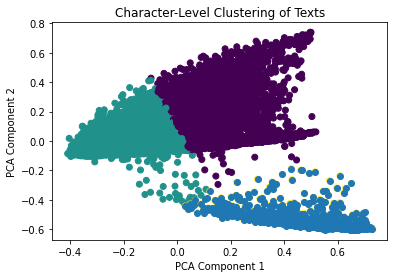

10685
17039
701


In [42]:
clusters = {'0': [], '1': [], '2':[]}

# selected_texts = X_reduced[labels == 2]

# Step 4: Visualization (optional)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis')
plt.scatter(selected_texts[:, 0], selected_texts[:, 1])
plt.title('Character-Level Clustering of Texts')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


# Display cluster assignments
for i, label in enumerate(labels):
#     print(f"Text {i} is in cluster {label}")
    clusters[str(label)].append(texts[i])

with open("cluster0.txt", 'w') as f:
    print(len(clusters['0']))
    txt = "\n#####\n".join(clusters['0'])
    f.write(txt)

with open("cluster1.txt", 'w') as f:
    print(len(clusters['1']))
    txt = "\n#####\n".join(clusters['1'])
    f.write(txt)
    
with open("cluster2.txt", 'w') as f:
    print(len(clusters['2']))
    txt = "\n#####\n".join(clusters['2'])
    f.write(txt)


    
    

Calculate Statistics

In [31]:
import os
import json
import numpy as np

forum_names = os.listdir("forums_annotated_cutoff/")

forum_data = {key: {} for key in forum_names}

for forum in forum_names:
    with open(f"forums_annotated_cutoff/{forum}", 'r') as f:
        data = json.load(f)
    
    posts_count = len(data)
    total_words_count = 0
    english_words_count = 0
    posts_no_english = 0
    
    posts_word_count = []

    for entry in data:
        text = entry['text']
        english_indices = entry['english_indices']
        total_words_count += len(text.split(" "))
        english_words_count += len(english_indices)
        posts_word_count.append(len(text.split(" ")))

        if len(english_indices) != 0:
            posts_no_english += 1


    forum_data[forum] = {
                        'total_words_count': total_words_count, 
                        'english_words_count': english_words_count, 
                        'percentage': english_words_count / total_words_count * 100,
                        'posts_count': posts_count,
                        'posts_with_no_english': posts_no_english,
                        'average_words_per_post': np.mean(posts_word_count),
                        'standard_deviation': np.std(posts_word_count),
                        'percentage_posts_with_english': posts_no_english / posts_count * 100
                        }

    # print(f"Forum: {forum}")
    # print(f"Total words: {total_words_count}")
    # print(f"English words: {english_words_count}")
    # print(f"Percentage of English words: {english_words_count / total_words_count * 100:.2f}%")

print(forum_data)
        

{'Ψυχαγωγία.json': {'total_words_count': 2209696, 'english_words_count': 169362, 'percentage': 7.6644932153563206, 'posts_count': 55383, 'posts_with_no_english': 38913, 'average_words_per_post': 39.898452593756204, 'standard_deviation': 58.3179910587888, 'percentage_posts_with_english': 70.26163263095174}, 'Λειτουργικά Συστήματα.json': {'total_words_count': 1409900, 'english_words_count': 120780, 'percentage': 8.566565004610256, 'posts_count': 31402, 'posts_with_no_english': 24896, 'average_words_per_post': 44.89841411375072, 'standard_deviation': 69.04421267306773, 'percentage_posts_with_english': 79.28157442201133}, 'Ειδήσεις.json': {'total_words_count': 23760, 'english_words_count': 977, 'percentage': 4.111952861952862, 'posts_count': 621, 'posts_with_no_english': 330, 'average_words_per_post': 38.26086956521739, 'standard_deviation': 53.70159302672301, 'percentage_posts_with_english': 53.14009661835749}, 'Hardware.json': {'total_words_count': 7254978, 'english_words_count': 398873,

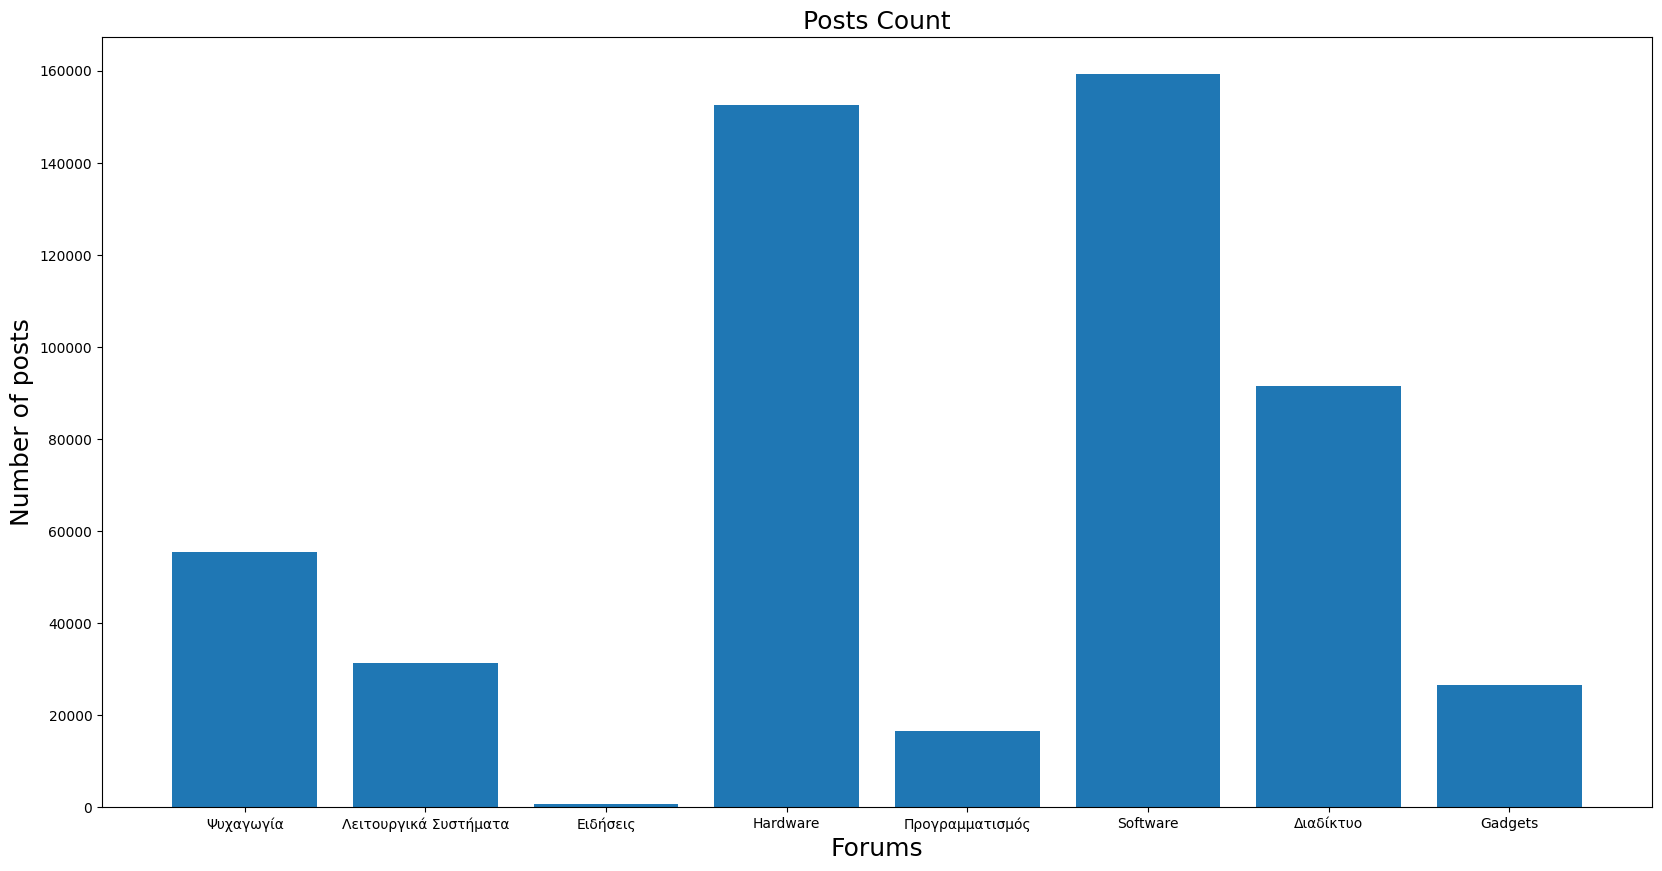

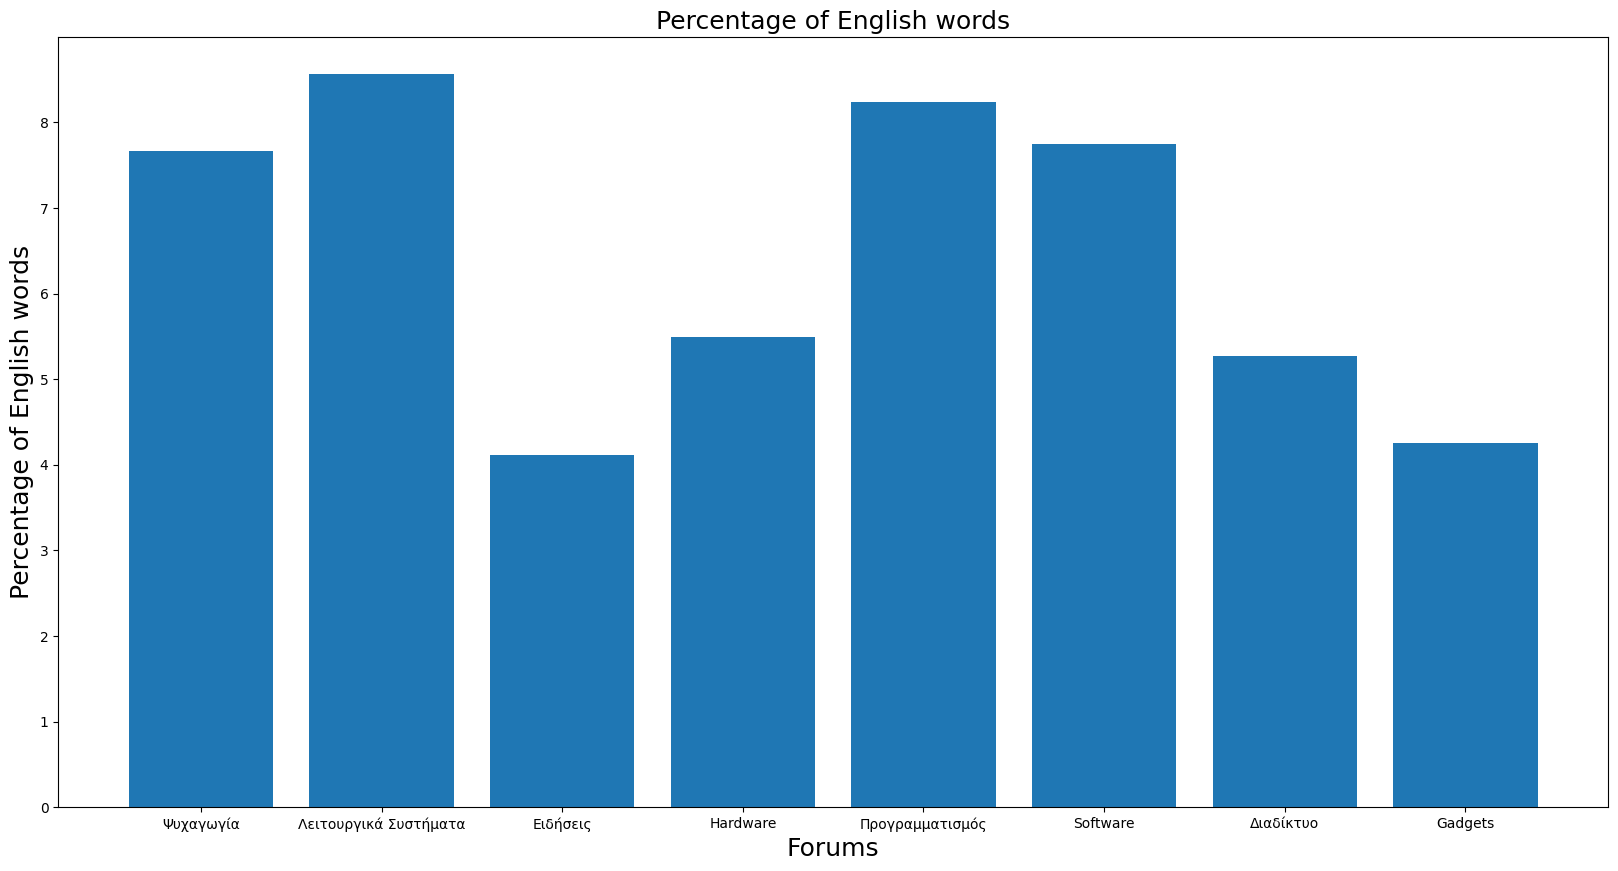

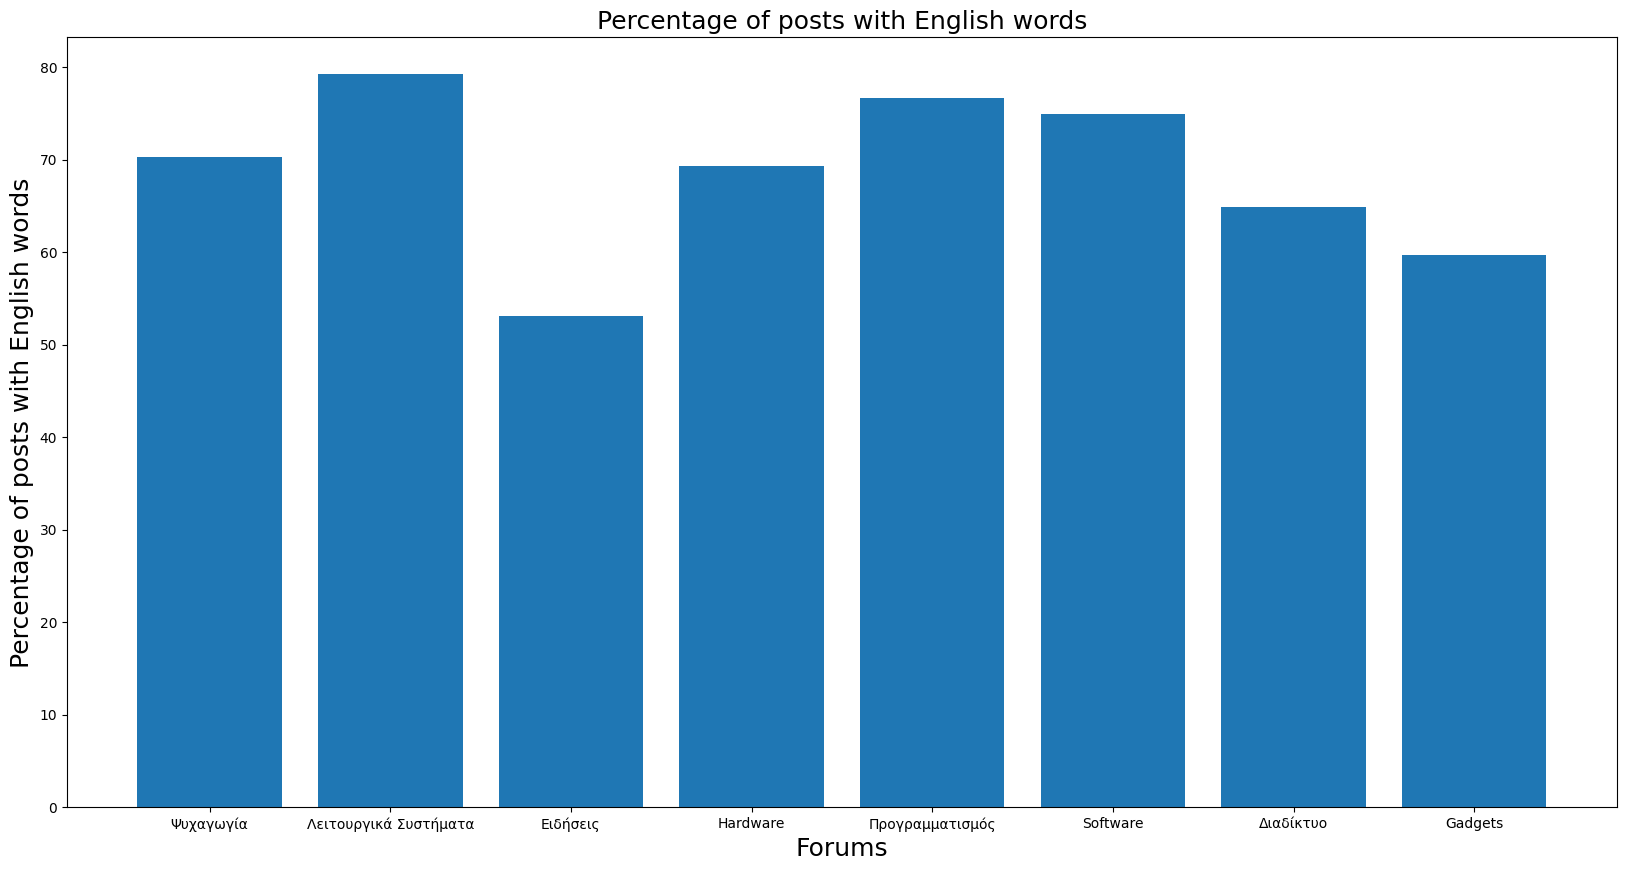

In [32]:
import matplotlib.pyplot as plt


forum_names = [forum.split('.')[0] for forum in forum_names]
# Plot the number of posts in each forum
plt.figure(figsize=(20, 10))
plt.bar(forum_names, [forum_data[forum]['posts_count'] for forum in forum_data.keys()])
plt.xlabel('Forums',fontsize=18)
plt.ylabel('Number of posts',fontsize=18)
plt.title("Posts Count", fontsize=18)
plt.savefig('plots/posts_count.png')
plt.show()

# Plot the percentage of english words in each forum
plt.figure(figsize=(20, 10))

plt.bar(forum_names, [forum_data[forum]['percentage'] for forum in forum_data.keys()])
plt.xlabel('Forums', fontsize=18)
plt.ylabel('Percentage of English words', fontsize=18)
plt.title("Percentage of English words", fontsize=18)
plt.savefig('plots/english_words_percentage.png')
plt.show()

# Plot the percentage of posts with no English words in each forum
plt.figure(figsize=(20, 10))
plt.bar(forum_names, [forum_data[forum]['percentage_posts_with_english'] for forum in forum_data.keys()])

plt.xlabel('Forums', fontsize=18)
plt.ylabel('Percentage of posts with English words', fontsize=18)
plt.title("Percentage of posts with English words", fontsize=18)
plt.savefig('plots/posts_with_english.png')
plt.show()

    

In [16]:
from flair.data import Sentence
from flair.models import SequenceTagger

# load tagger
tagger = SequenceTagger.load("flair/ner-english")

for forum_name in forum_names:
    with open(f"forums_info/forums_sampled/{forum_name}", "r") as f:
        forum_data = json.load(f)
    
    
    #Iterate over the comments in the forum
    for comment in forum_data:
        text = comment['text']
        sentence = Sentence(text)
        tagger.predict(sentence)

        for entity in sentence.get_spans('ner'):
            print(entity)

        # print("#################")

2024-09-08 15:04:49,779 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>
Span[0:5]: "Exo katevasei Siemens Mobility ToolKit" → ORG (0.7599)
Span[0:2]: "Mia xara" → PER (0.7034)
Span[38:40]: "Filika Dionisos" → PER (0.8969)
Span[0:3]: "kaneis den kserei" → PER (0.8008)
Span[2:4]: "kai poli" → PER (0.5913)
Span[0:3]: "Agorasa mia RADEON" → MISC (0.6749)
Span[207:209]: "kai Filika" → PER (0.7996)
Span[0:1]: "Xiaomi" → LOC (0.8344)
Span[65:66]: "Ellada" → LOC (0.9634)
Span[0:3]: "Sony Ericsson Vivaz" → MISC (0.7547)
Span[4:8]: "Sony Ericsson Aino VIDEO" → MISC (0.8963)
Span[0:1]: "na'sao" → LOC (0.3378)
Span[12:14]: "Stratos KeramidasMob" → ORG (0.5541)
Span[22:24]: "Fan Club" → ORG (0.7798)
Span[25:26]: "Melbourne" → LOC (0.9893)
Span[8:9]: "Nokia" → ORG (0.9021)
Span[10:11]: "SE" → LOC (0.7333)
Span[0:2]: "nai dokimasa" → PER (0.8927)
Span[0:2]: "

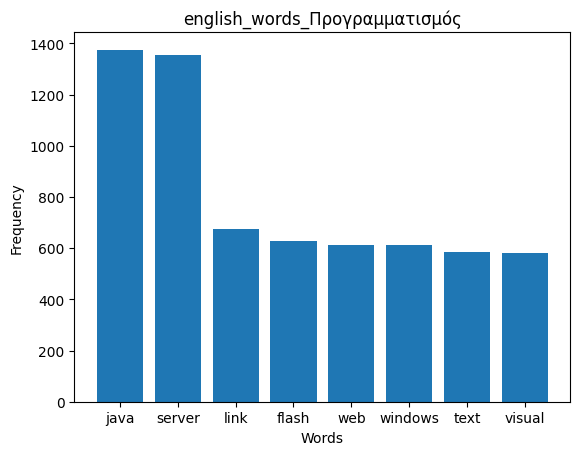

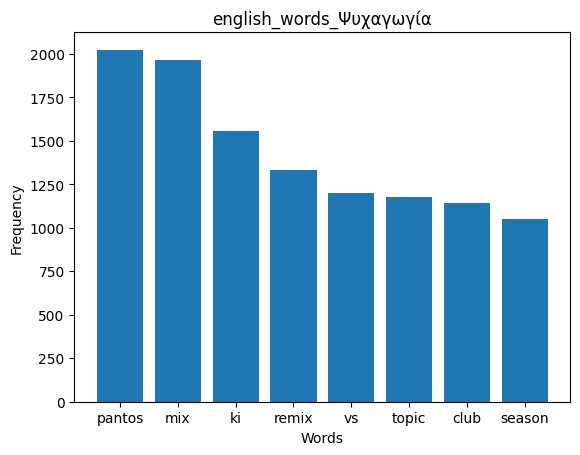

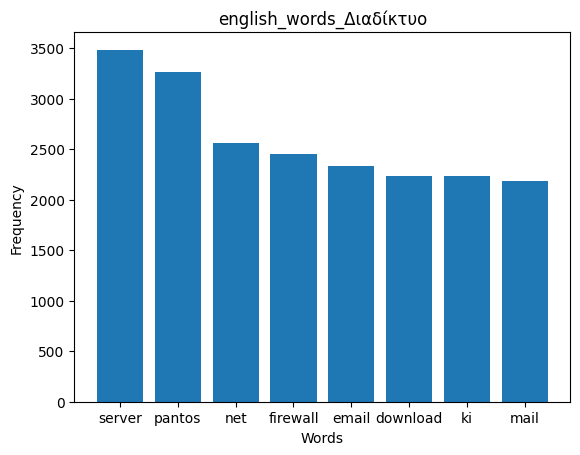

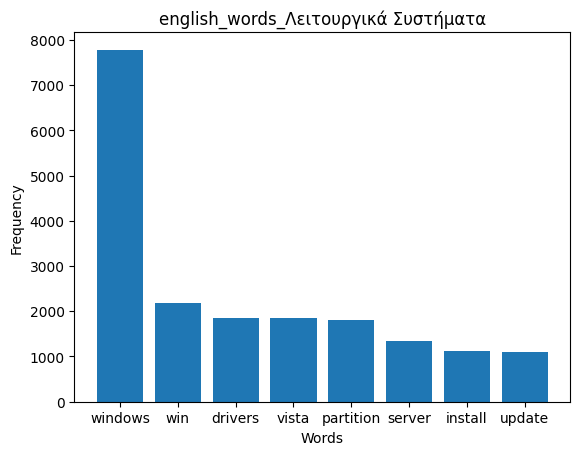

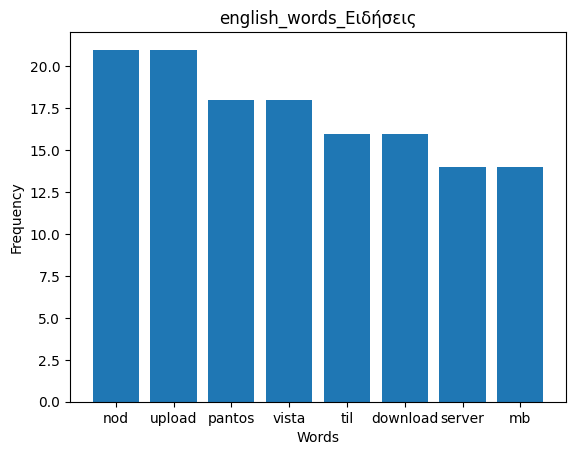

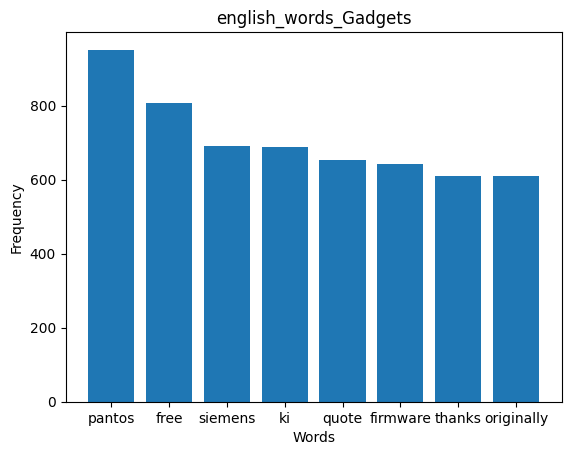

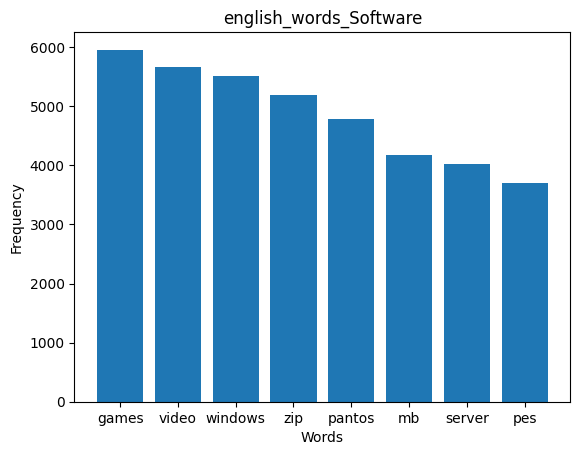

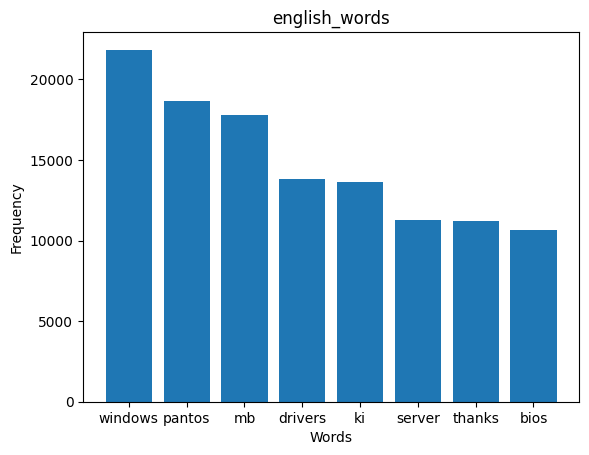

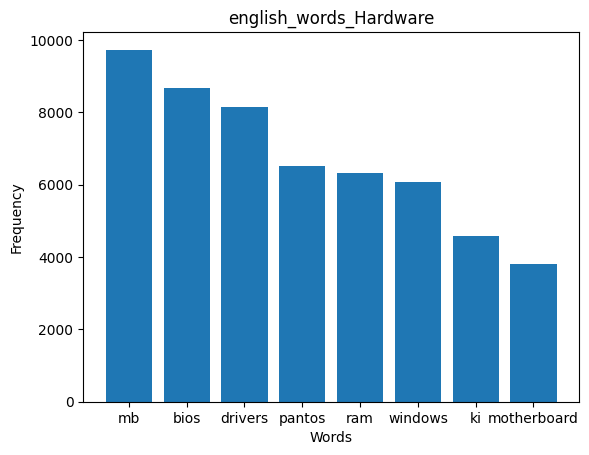

In [16]:
import pandas as pd 

forum_words = os.listdir("forums_info/english_words/")

for forum_name in forum_words:
    with open(f"forums_info/english_words/{forum_name}", "r") as f:
        word_data = json.load(f)
        # Create a dataframe from the json data, where one column are the keys and the other the values
    df = pd.DataFrame(word_data.items(), columns=["Word", "frequency"])

    # Sort the dataframe by the frequency column
    df = df.sort_values(by="frequency", ascending=False).reset_index(drop=True)

    plt.rcParams['figure.facecolor'] = 'white'

    cutoff = 8

    # Create a histogram of the frequency of the first 80 words
    plt.title(forum_name.split(".")[0])
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.bar(df["Word"][:cutoff], df["frequency"][:cutoff])
    plt.savefig(f'plots/{forum_name.split(".")[0]}.png')
    plt.show()
        

Calculate the statistic for the annotated data

In [25]:
import os
import json

forums_annotated = os.listdir("forums_info/forums_sampled/")

# forums_with_english = []
# for forum_name in forums_annotated:
#     with open(f"forums_info/forums_sampled/{forum_name}", "r") as f:
#         forum_data = json.load(f)
    
#     posts_with_english = 0

#     # Iterate over the posts and check which ones have English words
#     for comment in forum_data:
#         gt_indices = comment['gt_indices']
#         if(len(gt_indices) != 0):
#             posts_with_english += 1

forum_data = {key: {} for key in forums_annotated}

for forum in forums_annotated:

    print(forum)
    with open(f"forums_info/forums_sampled/{forum}", 'r') as f:
        data = json.load(f)
    
    posts_count = len(data)
    total_words_count = 0
    english_words_count = 0
    posts_no_english = 0
    
    posts_word_count = []

    for entry in data:
        text = entry['text']
        english_indices = entry['gt_indices']
        total_words_count += len(text.split(" "))
        english_words_count += len(english_indices)
        posts_word_count.append(len(text.split(" ")))

        if len(english_indices) != 0:
            posts_no_english += 1


    forum_data[forum] = {
                        'total_words_count': total_words_count, 
                        'english_words_count': english_words_count, 
                        'percentage': english_words_count / total_words_count * 100,
                        'posts_count': posts_count,
                        'posts_with_no_english': posts_no_english,
                        'percentage_posts_with_english': posts_no_english / posts_count * 100
                        }


print(forum_data)

    


Προγραμματισμός_sample.json
Hardware_sample.json
Gadgets_sample.json
Λειτουργικά Συστήματα_sample.json
Ειδήσεις_sample.json
Ψυχαγωγία_sample.json
Software_sample.json
Διαδίκτυο_sample.json
{'Προγραμματισμός_sample.json': {'total_words_count': 481, 'english_words_count': 56, 'percentage': 11.642411642411643, 'posts_count': 17, 'posts_with_no_english': 15, 'percentage_posts_with_english': 88.23529411764706}, 'Hardware_sample.json': {'total_words_count': 708, 'english_words_count': 106, 'percentage': 14.971751412429379, 'posts_count': 17, 'posts_with_no_english': 14, 'percentage_posts_with_english': 82.35294117647058}, 'Gadgets_sample.json': {'total_words_count': 631, 'english_words_count': 75, 'percentage': 11.885895404120443, 'posts_count': 17, 'posts_with_no_english': 13, 'percentage_posts_with_english': 76.47058823529412}, 'Λειτουργικά Συστήματα_sample.json': {'total_words_count': 401, 'english_words_count': 53, 'percentage': 13.216957605985039, 'posts_count': 16, 'posts_with_no_engli

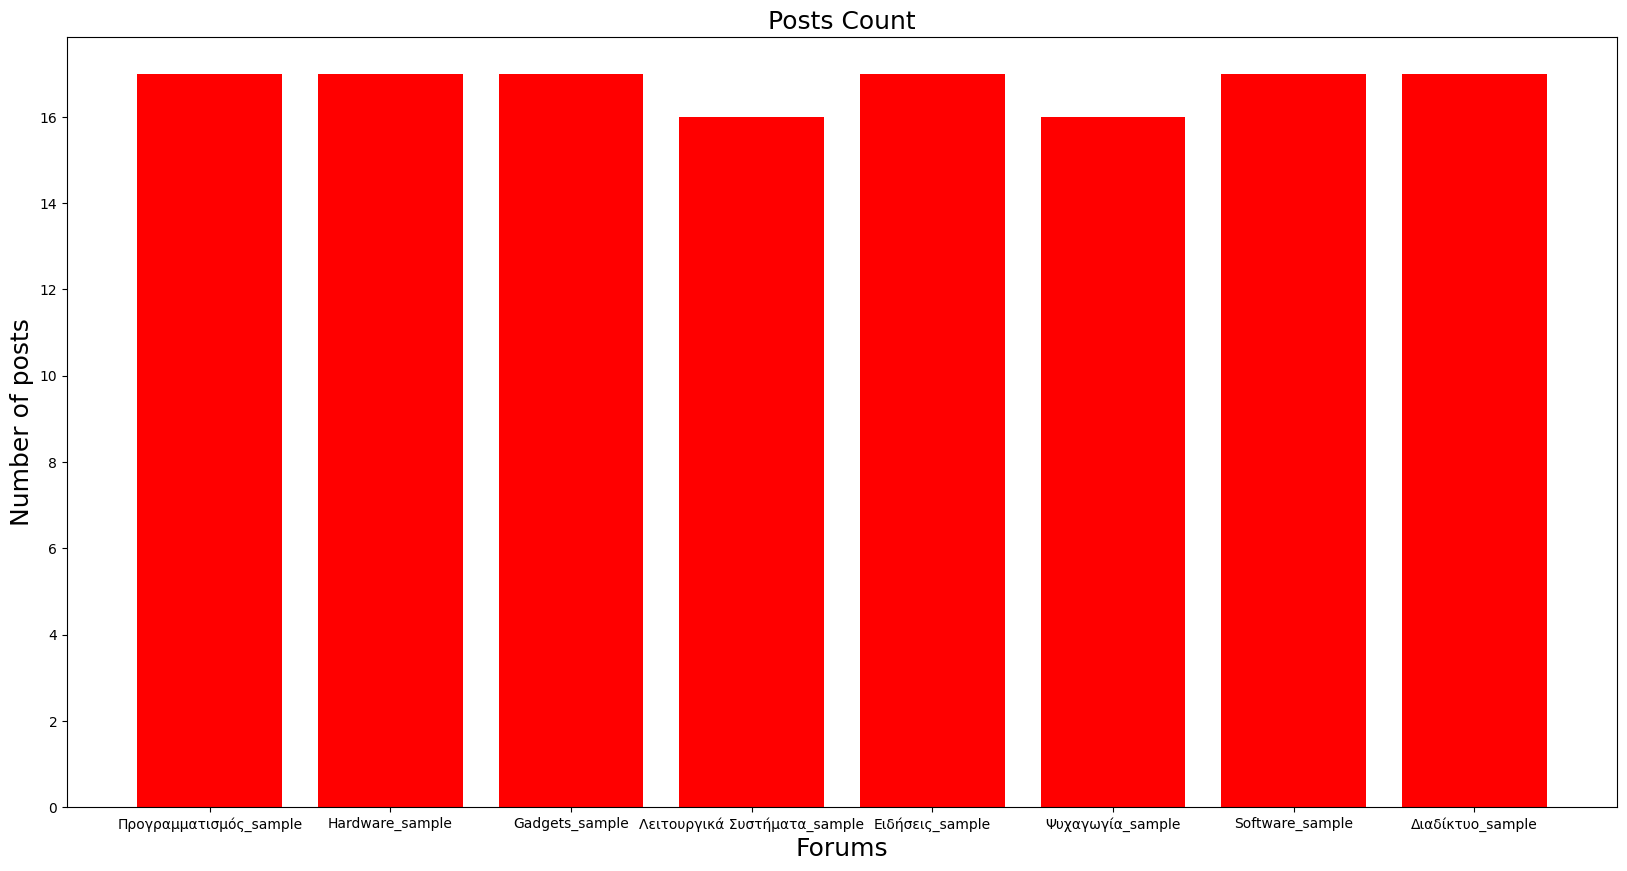

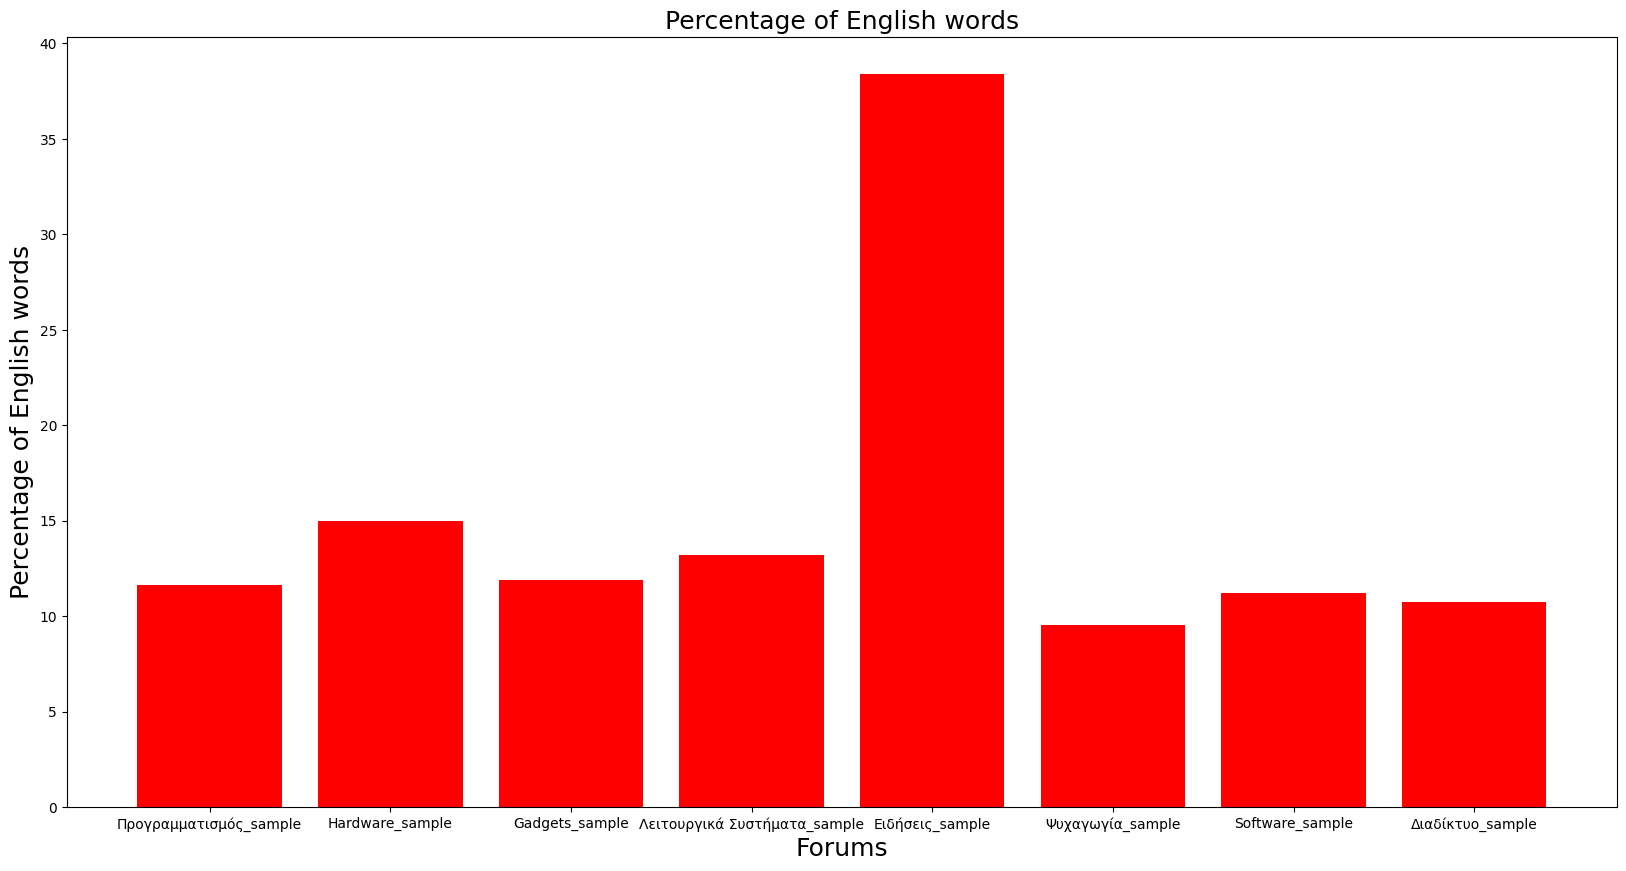

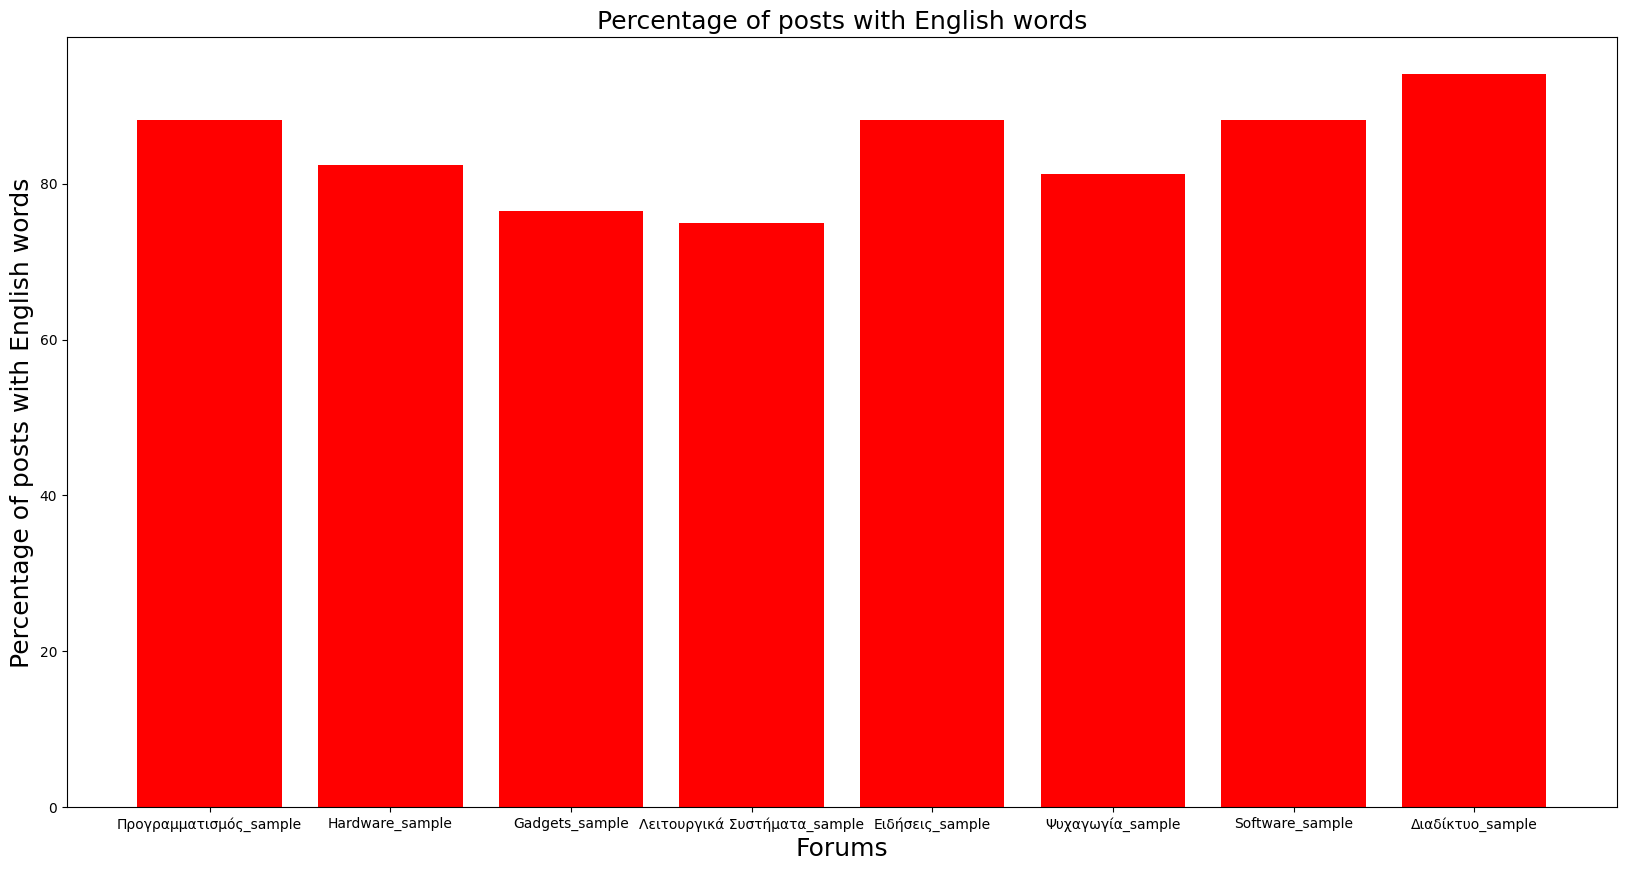

In [27]:
import matplotlib.pyplot as plt


forum_names = [forum.split('.')[0] for forum in forums_annotated]
# Plot the number of posts in each forum
plt.figure(figsize=(20, 10))
plt.bar(forum_names, [forum_data[forum]['posts_count'] for forum in forum_data.keys()], color='red')
plt.xlabel('Forums',fontsize=18)
plt.ylabel('Number of posts',fontsize=18)
plt.title("Posts Count", fontsize=18)
plt.savefig('plots/posts_count.png')
plt.show()

# Plot the percentage of english words in each forum
plt.figure(figsize=(20, 10))

plt.bar(forum_names, [forum_data[forum]['percentage'] for forum in forum_data.keys()], color='red')
plt.xlabel('Forums', fontsize=18)
plt.ylabel('Percentage of English words', fontsize=18)
plt.title("Percentage of English words", fontsize=18)
plt.savefig('plots/english_words_percentage.png')
plt.show()

# Plot the percentage of posts with no English words in each forum
plt.figure(figsize=(20, 10))
plt.bar(forum_names, [forum_data[forum]['percentage_posts_with_english'] for forum in forum_data.keys()], color='red')

plt.xlabel('Forums', fontsize=18)
plt.ylabel('Percentage of posts with English words', fontsize=18)
plt.title("Percentage of posts with English words", fontsize=18)
plt.savefig('plots/posts_with_english.png')
plt.show()

Study The frequency accross the years 

In [2]:
import os
import json

forums_annotated = os.listdir("forums_annotated/")

years_data = {}

for forum_name in forums_annotated:
    with open(f"forums_annotated/{forum_name}", "r") as f:
        forum_data = json.load(f)
    
    for post in forum_data:
        year = post['time'].split("-")[0]

        if year not in years_data:
            years_data[year] = {"total_words_count": 0, "english_words_count": 0, "posts_count": 0, 'posts':[]}
        
        years_data[year]['total_words_count'] += len(post['text'].split(" "))
        years_data[year]['english_words_count'] += len(post['english_indices'])
        years_data[year]['posts_count'] += 1
        years_data[year]['posts'].append(post['text'])

[3990, 35655, 45066, 80325, 77663, 97863, 109377, 84116]


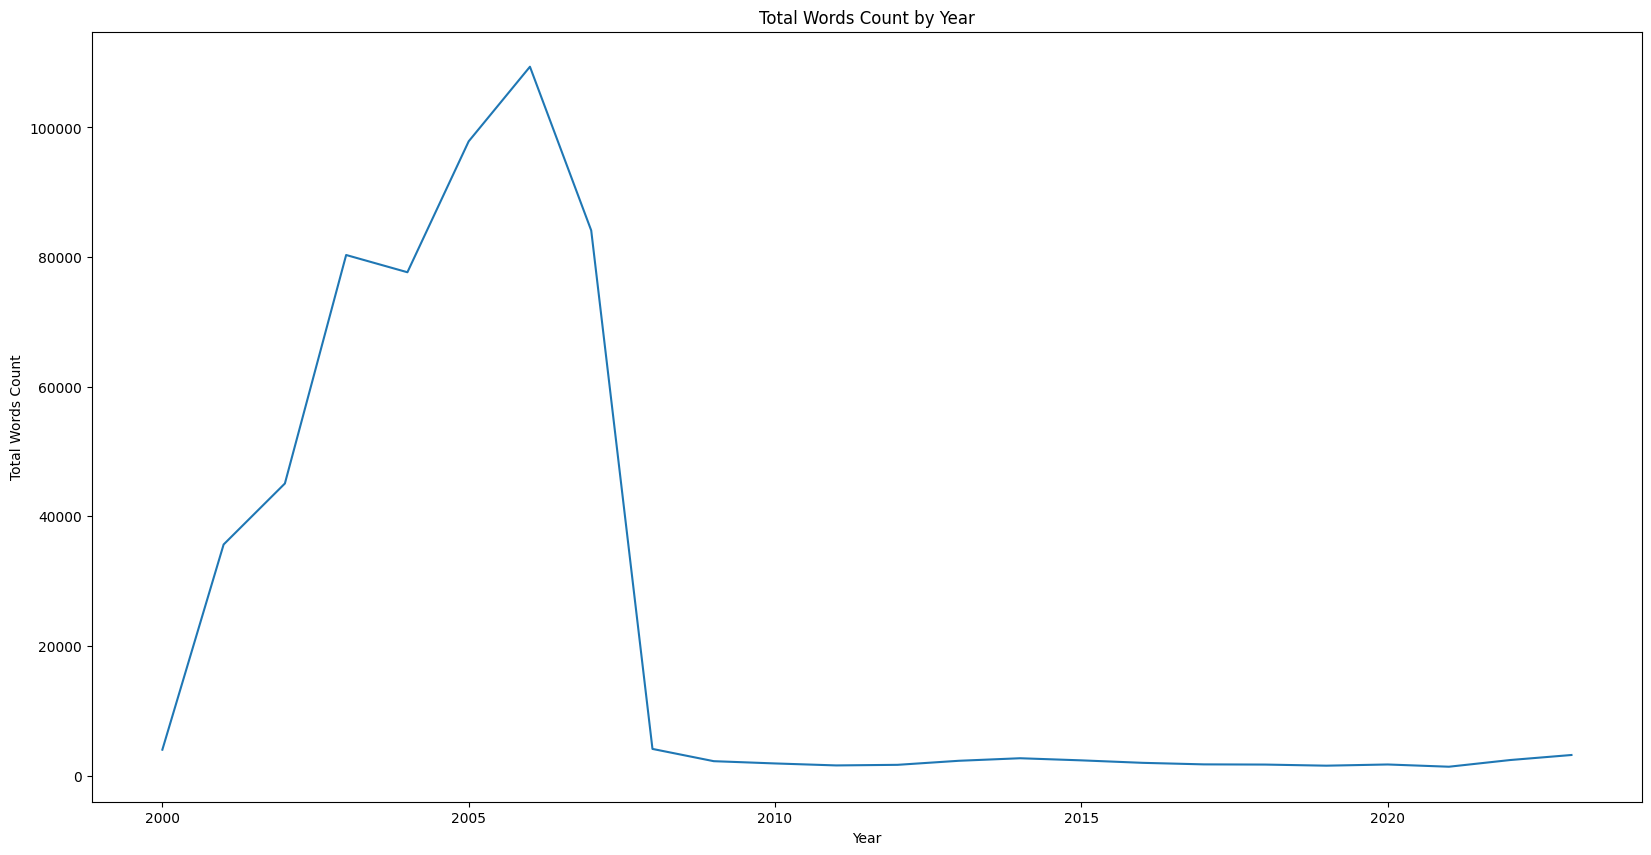

In [10]:
import matplotlib.pyplot as plt

# Extract the years and counts from years_data
years = list(range(2000, 2024))

counts = [years_data[str(year)]['posts_count'] for year in years]

print(counts[:8])
# Plot the data
plt.figure(figsize=(20, 10))
plt.plot(years, counts)
plt.xlabel('Year')
plt.ylabel('Total Words Count')
plt.title('Total Words Count by Year')
plt.show()

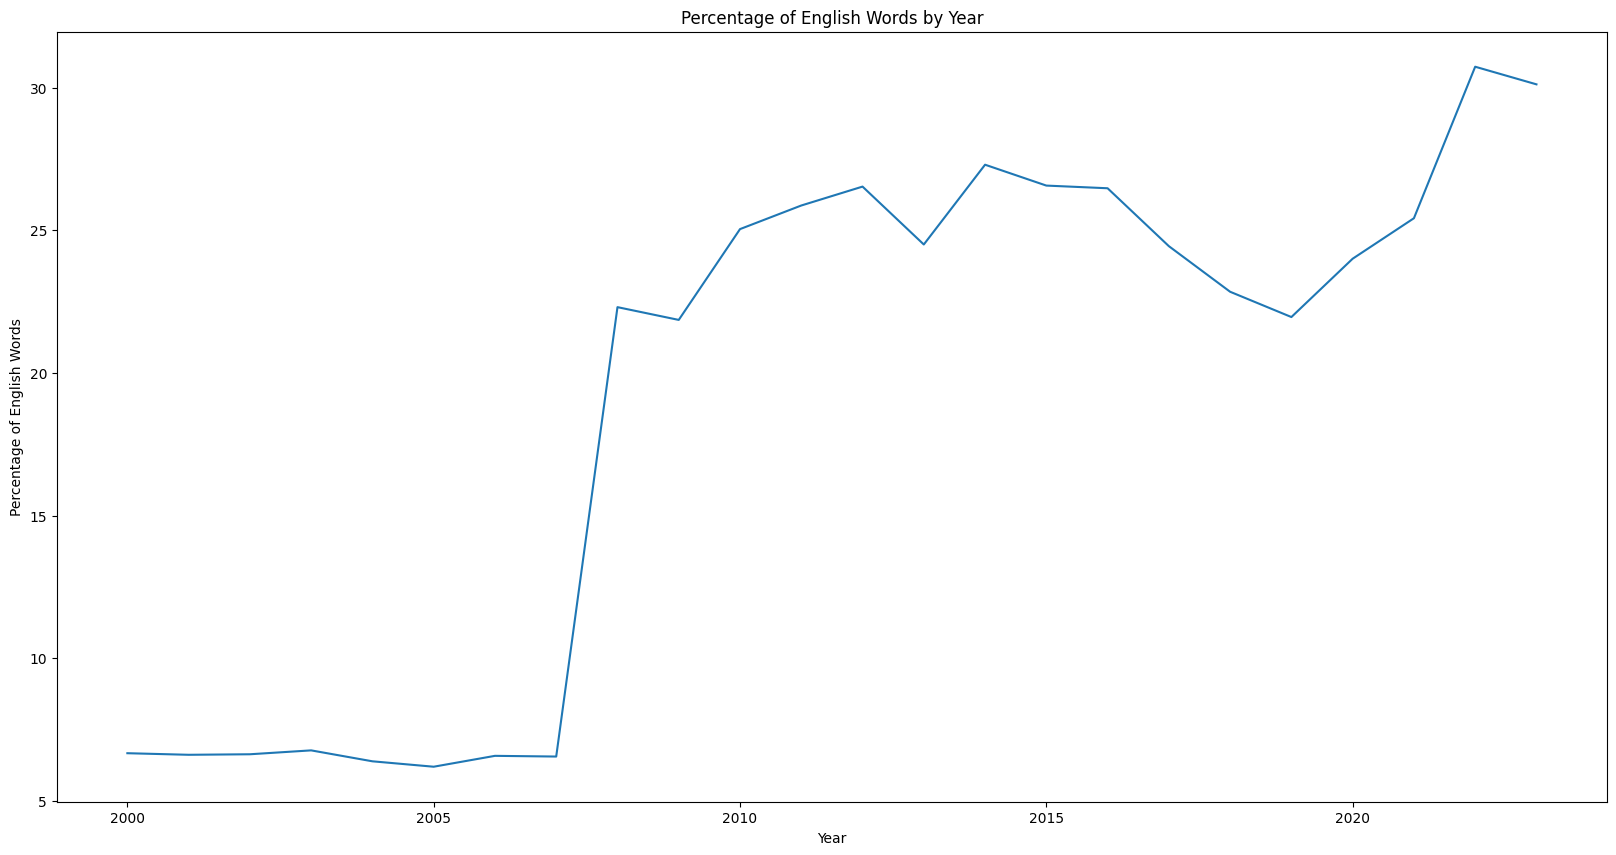

In [17]:
# Percentage of English words by year
percentages = [years_data[str(year)]['english_words_count'] / years_data[str(year)]['total_words_count'] * 100 for year in years]

plt.figure(figsize=(20, 10))
plt.plot(years, percentages)
plt.xlabel('Year')
plt.ylabel('Percentage of English Words')
plt.title('Percentage of English Words by Year')
plt.show()

In [14]:
# Calculate scores
import re


def detect_language(text):
    """
    Checks whether the majority of the letters in the input text are in the greek or the latin script
    It is used to identify whether the text is in greek or greeklish (latin script), in order to skip unnecessary conversions.

    Args:
        text (str): The input text

    Returns:
        script (str): The dominant script
    """
    # Filter out non-letter characters
    valid_characters = [char for char in text if char.isalpha()]
    
    # Count Greek and English letters
    greek_count = sum(1 for char in valid_characters if '\u0370' <= char <= '\u03FF' or '\u1F00' <= char <= '\u1FFF')
    english_count = sum(1 for char in valid_characters if '\u0041' <= char <= '\u005A' or '\u0061' <= char <= '\u007A')
    
    if(greek_count == 0 and english_count == 0):
        return "unknown"

    script = "greek" if greek_count >= english_count else "latin"
    return script

original_text = {
    "text" : "prepei na kanoume adjust sta kainouria guidelines",
    "gt_indices": [3, 6]
}

predicted_text = "πρεπει λολ να κανουμε adjust στα καινούρια ( guidelines"
TP = 0
FP = 0
FN = 0

indices_not_found = []
for index in original_text['gt_indices']:
    word = original_text['text'].split(" ")[index]
    # Check whether the word is in the predicted text
    if(word in predicted_text or word.lower() in predicted_text or word.upper() in predicted_text):
        TP += 1
    # If the word is not in the predicted text, it is a false negative
    else:
        FN += 1
        indices_not_found.append(index)

# Check for false positives

original_english_words = [original_text['text'].split(" ")[index] for index in original_text['gt_indices']]
print(original_english_words)
for i, word in enumerate(predicted_text.split(" ")):
    # only keep the letters
    stripped_word = " ".join(re.findall("[a-zA-Z]+", word))
    if detect_language(stripped_word) == "latin":
        if(word not in original_english_words and word.lower() not in original_english_words and word.upper() not in original_english_words):
            print(word)
            FP += 1

print(f"TP: {TP}")
print(f"FP: {FP}")
print(f"FN: {FN}")
recall = TP / (TP + FN)
precision = TP / (TP + FP)


print(f"Recall: {recall}")
print(f"Precision: {precision}")
        
        
    




['adjust', 'guidelines']
xlamoytsa
TP: 2
FP: 1
FN: 0
Recall: 1.0
Precision: 0.6666666666666666
